# Table of Contents

* [Introduction](#introduction)
* [Imports and Functions](#chapter1)
* [Creating the Data](#chapter2)
* [The Design Matrix](#chapter3)
    * [Section 3.1](#section_3_1)
* [The Tomographer Object](#chapter4)
    * [Section 4.1](#section_4_1)
* [Analyzing Output](#chapter5)
    * [Section 5.1](#section_5_1)

# Introduction <a class="anchor" id="introduction"></a>

In this tutorial we will use a toy example to illustrate how to use the Tomographer functionalities. We will create from scratch the data for this toy example, which will simply be two Gaussian distributions in the two dimensional image space. The goal will be to reconstruct the two distributions after artificially sectioning them (similar to the procedure that would be undertaken for real slices of tissue).

We will begin by importing the necessary files and functions. 

Next, data for the toy example will be created.

The design matrix is a fundamental aspect of Tomographer, and it's usage will be illustrated with an example. This will be followed by use of the Tomographer object. Inputs to the class instance will be described. Output reconstructions will be visualized.

The tutorial will end with a brief overview of some multivariable analysis that one can do with the output data. For this section of the tutorial however, real output reconstructions are used from Pogona vitticeps.

# Imports & Functions <a class="anchor" id="chapter1"></a>

In [1]:
%matplotlib inline
import os
os.environ["MKL_NUM_THREADS"] = "4" 
os.environ["NUMEXPR_NUM_THREADS"] = "4" 
os.environ["OMP_NUM_THREADS"] = "4" 

# Imports
import numpy as np
import pandas as pd
import h5py
import re
import os
import matplotlib
import matplotlib.pyplot as plt
import operator
import seaborn as sns
from matplotlib.colors import ListedColormap
matplotlib.rcParams['pdf.fonttype'] = 42


# Tomography
import tomography
from tomography.utils import pad_to_cube, pad_to_square, shift_simmetrize
from brainmap import *

# Clustering
import community
import networkx as nx

# Sklearn, scipy
from skimage.draw import circle
from scipy.stats import multivariate_normal
from scipy.optimize import minimize, Bounds
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis, NMF, non_negative_factorization
from scipy.stats import ttest_ind
from random import sample
import scipy.ndimage as sc
import seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import umap
from skimage import exposure
from sklearn.svm import SVR
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering, AgglomerativeClustering, ward_tree
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from skimage.measure import find_contours
from scipy.cluster.hierarchy import linkage, to_tree, dendrogram, fcluster
from skimage.morphology import convex_hull_image
from scipy.spatial.distance import pdist, squareform
from data_loaders import *

# other libraries
from collections import defaultdict
from sklearn.mixture import GaussianMixture
from scipy.stats import chi2


np.random.seed(11)

In [2]:
# The following functions are required to create data for simulations. 
# The function create_filename_data will use the data and section it as would be done
# for creating strips of tissue (the secondary slices)

def get_angle(angle_list):
    """angle_list: list containing designated angles at positions 5:
    anglexxx
    for example: ['angle89', 'angle100']"""
    new_array = np.empty(0)
    array = [np.append(new_array, int(x[5:])) for x in angle_list]
    return np.array(array).flatten()


def random_2_points(dist, accu=10, xc= 100, yc=100):
    ang_dir = np.random.uniform(0, 2*np.pi)
    deltay = accu * np.sin(ang_dir)
    deltax = accu * np.cos(ang_dir)
    mu1 = np.array([xc + deltax, yc + deltay ])

    ang_dir = np.random.uniform(0, 2*np.pi)
    deltay = dist * np.sin(ang_dir)
    deltax = dist * np.cos(ang_dir)
    mu2 = mu1 + np.array([deltax, deltay])
    return mu1, mu2


def generate_gaussians(mu1, mu2, sigma1, sigma2, level_express=1, shape=(200,200)):
    X,Y = np.meshgrid(range(shape[0]), range(shape[1]))
    pos = np.column_stack([X.flat[:], Y.flat[:]])
    density = multivariate_normal.pdf(pos, mean=mu1, cov=sigma1) + multivariate_normal.pdf(pos, mean=mu2, cov=sigma2)
    average_expression = level_express * density / np.max(density)
    return (average_expression).reshape(shape)

def create_filename_data(file_path, angles_names, angles_values, var, factor, mask, width, error=True):
    """Creates h5py file with data. Noise is added automatically unless argument error=False
    
    Args:
    
    file_path: string path to .h5py
    angles_names: list of angle names in format anglexxx
    angles_values: integer values of angle names
    var: dictionary containing gene_list and attributes
    factor: amount of noise (poisson) to add
    error: if True, adds error, else data is taken as given"""
    
    if os.path.isfile(file_path):
        !rm $file_path
    
    fout = h5py.File(file_path, 'w')
    D, proj_len = tomography.core.build_Design_Matrix(angles_values,
                                                  [width,]*len(angles_names),
                                                  mask,
                                                  0.1,
                                                  notation_inverse=True,
                                                  return_projlen=True)
    profiles = []
    for g_name, g_ in var.items():
        b_ = D.dot((g_.data*mask).flat[:])
        cum_proj_len = np.hstack([[0], proj_len]).cumsum()
        for i, name in enumerate(angles_names):
            if error:
                tmp = np.random.poisson(b_[cum_proj_len[i]:cum_proj_len[i+1]] / 
                                        np.mean(b_[cum_proj_len[i]:cum_proj_len[i+1]]) * factor, size=None)
                
                
            else:
                tmp = b_[cum_proj_len[i]:cum_proj_len[i+1]]
            fout.create_dataset("genes/%s/%s" % (g_name, name), data=tmp)
            profiles.append(tmp)
    for i, name in enumerate(angles_names):
        fout.create_dataset("coordinates/%s" % name, data=np.arange(proj_len[i]))
    
    fout.close()
    return profiles



# Creating the Data <a class="anchor" id="chapter2"></a>

We will begin by creating a mask of our toy tissue. The mask will be a simple circle in this case, binarized. The mask is a very important component of the Tomographer algorithm, as it is used to help create the design matrix (for more details, see Online methods of the paper).

In real tissue, reference masks are grayscale images which can be for example taken as a brightfield microscopy images. This implies then that values are not binary!

The reference mask is passed to the tomography object (which we will see later), and this is accompanied, importantly, by a threshold that is used to binarize the continuous grayscale image to create the mask. 

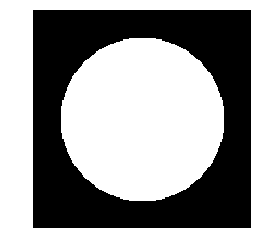

In [3]:
# Create mask
mask = np.zeros((200, 200), dtype=np.uint8)
rr, cc = circle(100, 100, 75)
mask[rr, cc] = 1

# find the contour of the mask
cnts = find_contours(mask, 0.5)[0]

# plot the mask
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

Now we are going to generate our data! The data will be a set of images which contain two randomly distributed Gaussians that are separated by varying distances. These data are stored in a dictionary, `var`, whose keys are the distances between the two gaussians in the 2D image.

In [4]:
generated_data = defaultdict(dict)
obj = type('namespace', (object,), {})
var = dict()

level_express = 20 # the expression level of the gaussian
radius = 10 # the sigma value of the gaussian
distances = np.linspace(3,20, 5)# np.linspace(3,20, 15)

# loop over distances
for d in distances:
    mu1, mu2 = random_2_points(d, accu=10, xc= 100, yc=100)
    Z = generate_gaussians(mu1, mu2, sigma1=radius, sigma2=radius, level_express=level_express, shape=(200,200))
    generated_data[d] = Z
    var[f'{d}'] = obj()
    var[f'{d}'].data = Z



Here is an example of a trial of distance 20. The white line demarcates the image mask that was created above.

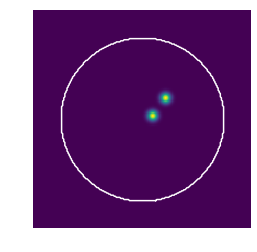

In [5]:
plt.imshow(var['20.0'].data)
plt.axis('off')
plt.plot(cnts[:,1], cnts[:,0], c='white')
plt.show()

We will now use this data to artifically cut secondary slices using the defined angle and width parameters

In [6]:
angles_names = ['angle41', 'angle77', 'angle113', 'angle149', 'angle185']
factor=20
width=10
first_points = np.zeros(len(angles_names))
angles_values = np.deg2rad(get_angle(angles_names))

In [7]:
np.random.seed(100)
tmp0 = create_filename_data('resolution_testing_noise_tutorial.hdf5', angles_names, angles_values, var, factor, mask, width,error=False)


# The Design Matrix <a class="anchor" id="chapter3"></a>

To create the design matrix, one must know all the parameters that were used with respect to cutting of the primary slices to create secondary slices. This implies
    * The angles that were used
    * The width of the secondary slices
    * The mask
    * The threshold for the mask (since we are using a binary mask this is not relevant)
    
Multiplication of the design matrix by the image will return a projection of the signal across all angles (which are stacked together)

In [8]:
D, proj_len = tomography.core.build_Design_Matrix(angles_values,
                                                  [width,]*len(angles_names),
                                                  mask,
                                                  0.1,
                                                  notation_inverse=True,
                                                  return_projlen=True)

We will quickly visualize how the dot product of the design matrix, D, and an image results in a projection vector. The `proj_len` variable which is the second output of the function describes how many secondary slice samples are in one angle. Hence, the cumulative sum of the `proj_len` variable will allow us to plot vertical lines where this delineation happens in the resultant vector of the dot product between D and the image.

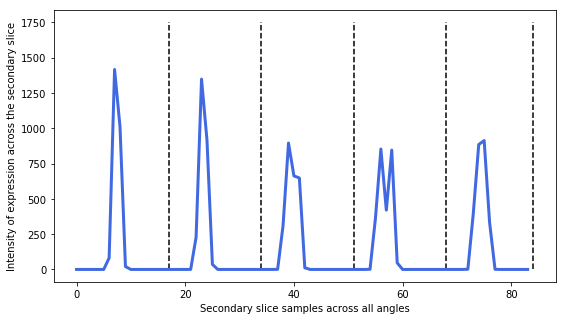

In [9]:
fig = plt.figure(figsize=(9,5))

cum_sum = np.cumsum(proj_len)
for sum_ in cum_sum:
    plt.vlines(sum_, 0, 1750, linestyles='--')
    
    
plt.plot(np.dot(D, var['20.0'].data.flatten()), linewidth=3, c='royalblue')

plt.ylabel('Intensity of expression across the secondary slice')
plt.xlabel('Secondary slice samples across all angles')
plt.show()


# The Tomographer Object <a class="anchor" id="chapter4"></a>

The Tomographer Object requires two essential inputs in order to perform a reconstruction:
    - A configuration file which contains information to create a design matrix. Note that the design matrix will be created internally by the Tomographer() object when it is called.
    - A data file which contains the measures projections which will be used to recreate the image in the two dimensional space

In [10]:
# create the configuration file
rec_conf = tomography.ReconstructionConfig(angles_names=angles_names,
                                           mask=mask,mask_thrs=0.1,
                                           reference_mask=mask,
                                           symmetry=False,
                                           masked_formulation=True,
                                           angles_values=angles_values,
                                           first_points=first_points,
                                           widths=[width,]*len(angles_names))


# Setting up Tomographer
tg = tomography.Tomographer() # initialize object
tg.load_cfg(rec_conf) # load the config file
tg.connect_data('resolution_testing_noise_tutorial.hdf5') # connect the hdf5 file with the projection data
# mask_idx = np.argwhere(mask.flatten() == 1).squeeze()

 It might results in errors 
Filling with sorted(list(self.f["genes"].keys()))


Once the Tomographer object is loaded with the configuration file and the projection data file, reconstructions can begin! Here we will store reconstructions in a dictionary, where keys are the distances that were set between the two Gaussian points in each instance.

We ask Tomographer to select what it thinks is the best alpha / beta hyperparameter pair by setting the parameter `alpha_beta` to 'auto'. If one wants to insert a desired alpha / beta, one can do so by passing a tuple. The remainder of the arguments in `crossval_kwargs` are parameters used for the automatic grid search for the hyperparameter values.

In [11]:


# Initialize a dictionary to store the reconstruction
gaussian_reconstructions = {}


# Begin reconstructions
for i, d in enumerate(distances):

    reconstruction = tg.reconstruct(f'{d}', alpha_beta='auto', crossval_kwargs={'domain': [(0,4), (0.05,8)],
                                                            'logged_grid':False, 
                                                            'extra_evals': 7,
                                                            'style' : 'grid',
                                                            'gradient_iter' : 5,
                                                            'initial_grid_n': 5})
    print(f'Distance:{d}')
    gaussian_reconstructions[d] = reconstruction


The set cost function is ignored! LCB acquisition does not make sense with cost.
Distance:3.0
The set cost function is ignored! LCB acquisition does not make sense with cost.
Distance:7.25
The set cost function is ignored! LCB acquisition does not make sense with cost.
Distance:11.5
The set cost function is ignored! LCB acquisition does not make sense with cost.
Distance:15.75
The set cost function is ignored! LCB acquisition does not make sense with cost.
Distance:20.0


# Analyzing Output <a class="anchor" id="chapter5"></a>

In [17]:
v_key = list(var.keys())

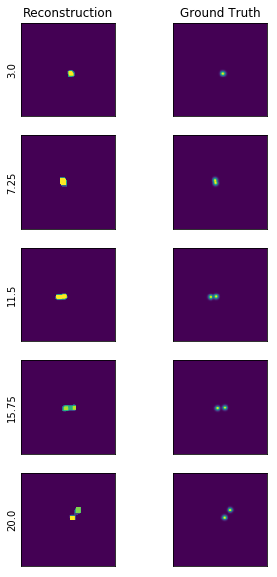

In [39]:
fig = plt.figure(figsize=(5,10))
gs = plt.GridSpec(len(distances), 2)

for i, d in enumerate(distances):
    
    reconstruction = gaussian_reconstructions[d]
    ground_truth = var[v_key[i]].data
    
    
    ax = plt.subplot(gs[i * 2])
    ax1 = plt.subplot(gs[i * 2 + 1])
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    
    ax.imshow(reconstruction, vmax=10)
    ax1.imshow(ground_truth)
    
    ax.set_ylabel(str(d)[:5])
    if i == 0:
        ax.set_title('Reconstruction')
        ax1.set_title('Ground Truth')

Instead of comparing the images of the reconstruction to the ground truth, we can also compare projection values which were used to fit the model. This might also give us some hints about why the reconstruction may not as been as good as we had hoped.

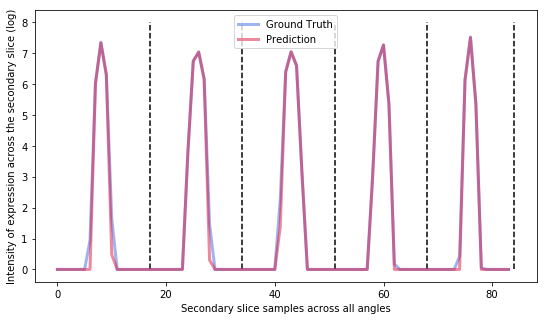

In [46]:
fig = plt.figure(figsize=(9,5))

cum_sum = np.cumsum(proj_len)
for sum_ in cum_sum:
    plt.vlines(sum_, 0, 8, linestyles='--')
    
    
true_profile = np.dot(D, var['11.5'].data.flatten())
predicted_profile = np.dot(D, gaussian_reconstructions[11.5].flatten())
    
plt.plot(np.log1p(true_profile), linewidth=3, c='royalblue', alpha=0.5, label='Ground Truth')
plt.plot(np.log1p(predicted_profile), linewidth=3, c='crimson', alpha=0.5, label='Prediction')

plt.ylabel('Intensity of expression across the secondary slice (log)')
plt.xlabel('Secondary slice samples across all angles')
plt.legend()
plt.show()
